In [79]:
import sys
# sys.path.append('/home/abigaile-woodbury/Research/cp_reach')  # UPDATE path as needed
sys.path.append('/home/micah/Research/development/cp_reach')
import json
import numpy as np
import matplotlib.pyplot as plt
import cp_reach as cp

import cp_reach.satellite.invariant_set3 as invariant_set3
import cp_reach.satellite.plotting as plotting
import cp_reach.satellite.HCW as HCW
import cp_reach.satellite.TH_LTV as TH_LTV
import cp_reach.physics.rigid_body as rigid_body
import sympy as sp

import cp_reach.satellite.mission2 as sat_sim
import cyecca.lie as lie
import casadi as ca

In [80]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
%autoreload 2

# Define Mission Parameters

In [82]:
thrust = 0
ang_vel_dist_deg = 0.01 # in degrees
ang_vel_dist_rad = np.deg2rad(ang_vel_dist_deg)
gravity_err = 0.00 # m/s^2
accel_dist = 0.5 #m/s^2
Kp = 1
Kd = 1
Kpq = 1
Kdq = 1
control_gains = (Kp, Kd, Kpq, Kdq)
acc = [thrust, 0, 0]

In [83]:
def do_burn_reference(t_vect):
    sat_burn = sat_sim.SatSimBurn()
    data = []
    p_index = sat_burn.model['p_index']
    sat_burn.model['p0_dict']['w_d_phase'] = 0
    sat_burn.model['p0_dict']['w_d_freq'] = 0
    
    sat_burn.model['p0_dict']['w_d_amp'] = 0
    sat_burn.model['p0_dict']['a_d_amp'] = 0
    sat_burn.model['p0_dict']['thrust'] = thrust
    sat_burn.model['p0_dict']['Kp'] = Kp
    sat_burn.model['p0_dict']['Kd'] = Kd
    sat_burn.model['p0_dict']['Kpq'] = Kpq
    sat_burn.model['p0_dict']['Kdq'] = Kdq
    
    res = sat_burn.simulate(t_vect, integrator='rk')
    return res

def do_burn_monte_carlo(t_vect, n_runs=10):
    sat_burn = sat_sim.SatSimBurn()
    data = []
    for i in range(n_runs):
        p_index = sat_burn.model['p_index']
        sat_burn.model['p0_dict']['w_d_x_phase'] = np.random.uniform(0, 2*np.pi)
        sat_burn.model['p0_dict']['w_d_y_phase'] = np.random.uniform(0, 2*np.pi)
        sat_burn.model['p0_dict']['w_d_z_phase'] = np.random.uniform(0, 2*np.pi)
        sat_burn.model['p0_dict']['w_d_freq'] = 10**np.random.uniform(-2, 1)

        
        sat_burn.model['p0_dict']['w_d_amp'] = ang_vel_dist_rad
        sat_burn.model['p0_dict']['a_d_amp'] = accel_dist
        sat_burn.model['p0_dict']['thrust'] = thrust
        sat_burn.model['p0_dict']['Kp'] = Kp
        sat_burn.model['p0_dict']['Kd'] = Kd
        sat_burn.model['p0_dict']['Kpq'] = Kpq
        sat_burn.model['p0_dict']['Kdq'] = Kdq

        res = sat_burn.simulate(t_vect, integrator='rk')
        data.append(res)
    return data

# 10 Second Burn - Monte Carlo and Reference

In [84]:
# Perform Monte Carlo Simulation for Burn Phase
t_burn_vect = np.arange(0, 10, 0.01)
data_burn_ref = do_burn_reference(t_burn_vect)
data_burn = do_burn_monte_carlo(t_vect=t_burn_vect, n_runs=100)

## LMI for log-linearized system

In [85]:
xi_points, eta_points, bounds_log, sol = invariant_set3.solve(ang_vel_dist_rad, accel_dist, acc, control_gains, num_points=1000)

In [86]:
bounds_log

array([[-0.78565857,  0.78565857],
       [-0.78565858,  0.78565858],
       [-0.78565858,  0.78565858],
       [-0.73660652,  0.73660652],
       [-0.73660653,  0.73660653],
       [-0.73660653,  0.73660653],
       [-0.50002018,  0.50002018],
       [-0.50002018,  0.50002018],
       [-0.50002018,  0.50002018]])

In [87]:
# i = 4
# j = 5
# plt.scatter(eta_points[i,:],eta_points[j,:])
# plt.scatter(xi_points[i,:],xi_points[j,:])
# plt.xlabel('deltav y')
# plt.ylabel('deltav z')

## LMI for HCW system

In [88]:
mu = 3.986e14      # [m^3/s^2]
r0 = 42164e3          # [m]
ref_n = np.sqrt(mu / r0**3)

hcw_sol = HCW.solve_hcw_invariant_set(ref_n, accel_dist, Kp=Kp, Kd=Kd)
hcw_sol
mu1 = hcw_sol['mu']  # acceleration disturbance multiplier
P_hcw = hcw_sol['P']
val_hcw = mu1 * accel_dist**2 
P_hcw_scaled = P_hcw / val_hcw
hcw_points = HCW.sample_ellipsoid_boundary_6(P_hcw_scaled, n=600)

hcw_min = np.min(hcw_points, axis=1)
hcw_max = np.max(hcw_points, axis=1)
bounds_hcw = np.column_stack([hcw_min, hcw_max])

In [89]:
bounds_hcw

array([[-0.78406008,  0.78406008],
       [-0.78406008,  0.78406008],
       [-0.78406007,  0.78406007],
       [-0.73658766,  0.73658766],
       [-0.73658767,  0.73658767],
       [-0.73658767,  0.73658767]])

## LMI for TH system

In [90]:
mu = 3.986e14      # [m^3/s^2]
ref_orbit = data_burn_ref['xf'][1:7,:].T
bounds= TH_LTV.th_param_bounds_from_traj(ref_orbit, mu)
th_sol = TH_LTV.solve_YA_TH_LTV_invariant_set_from_bounds(bounds, accel_dist,Kp=Kp, Kd=Kd)
print(th_sol)
mu1 = th_sol['mu']  # acceleration disturbance multiplier
P_th = th_sol['P']
val_th = mu1 * accel_dist**2
print(mu1)
P_th_scaled = P_th / val_th
th_points = TH_LTV.sample_ellipsoid_boundary_6(P_th_scaled, n=600)

th_min = np.min(th_points, axis=1)
th_max = np.max(th_points, axis=1)
bounds_th = np.column_stack([th_min, th_max])

{'P': array([[ 1.59803048e-09, -5.83333826e-19, -1.57989390e-18,
         3.57144630e-10, -7.01626716e-20,  4.12400924e-14],
       [-5.83333826e-19,  1.59803044e-09, -7.20538800e-18,
         5.71368034e-20,  3.57144633e-10,  1.48936063e-19],
       [-1.57989390e-18, -7.20538800e-18,  1.59803045e-09,
        -4.12399875e-14,  1.44293721e-19,  3.57144628e-10],
       [ 3.57144630e-10,  5.71368034e-20, -4.12399875e-14,
         8.17200952e-10, -1.98384571e-19, -5.90692091e-19],
       [-7.01626716e-20,  3.57144633e-10,  1.44293721e-19,
        -1.98384571e-19,  8.17200940e-10, -2.62689836e-18],
       [ 4.12400924e-14,  1.48936063e-19,  3.57144628e-10,
        -5.90692091e-19, -2.62689836e-18,  8.17200943e-10]]), 'mu': 1.7403495052666043e-07, 'cost': 4.350873763166511e-08, 'alpha': np.float64(0.2928945320209625), 'prob': Problem(Minimize(Expression(AFFINE, NONNEGATIVE, ())), [PSD(Expression(AFFINE, UNKNOWN, (6, 6))), PSD(Expression(AFFINE, UNKNOWN, (9, 9))), PSD(Expression(AFFINE, UNKNO

In [91]:
bounds_th

array([[-5.49301474,  5.49301474],
       [-5.49301481,  5.49301481],
       [-5.4930148 ,  5.4930148 ],
       [-7.6814255 ,  7.6814255 ],
       [-7.68142557,  7.68142557],
       [-7.68142554,  7.68142554]])

In [92]:
# def burn_plotting(data_burn, bounds_log, bounds_hcw, bounds_th):
#     fig, axes = plt.subplots(8, 1, figsize=(10, 20))
#     axes[0].set_title('Burn Phase')

#     # # ---------- Attitude ----------
#     # plotting.plot_burn_attitude(axes[1], data_burn, label='Simulation')
#     # for i, comp in enumerate(['roll','pitch','yaw']):
#     #     axes[1].axhline(y=np.rad2deg(bounds_log[6+i, 0]), linestyle='--', 
#     #                     label=f'LOG {comp} min')
#     #     axes[1].axhline(y=np.rad2deg(bounds_log[6+i, 1]), linestyle='--', 
#     #                     label=f'LOG {comp} max')

#     #     axes[1].axhline(y=np.rad2deg(bounds_hcw[6+i, 0]), linestyle='--', 
#     #                     label=f'HCW {comp} min')
#     #     axes[1].axhline(y=np.rad2deg(bounds_hcw[6+i, 1]), linestyle='--', 
#     #                     label=f'HCW {comp} max')

#     #     axes[1].axhline(y=np.rad2deg(bounds_th[6+i, 0]), linestyle='--', 
#     #                     label=f'TH {comp} min')
#     #     axes[1].axhline(y=np.rad2deg(bounds_th[6+i, 1]), linestyle='--', 
#     #                     label=f'TH {comp} max')

#     # axes[1].legend()

#     # ---------- Vx ----------
#     plotting.plot_burn_delta_vx_error(axes[2], data_burn, label='Simulation')
#     axes[2].axhline(y=bounds_log[3, 0], linestyle='--', label='LOG Vx min')
#     axes[2].axhline(y=bounds_log[3, 1], linestyle='--', label='LOG Vx max')
#     axes[2].axhline(y=bounds_hcw[3, 0], linestyle='--', label='HCW Vx min')
#     axes[2].axhline(y=bounds_hcw[3, 1], linestyle='--', label='HCW Vx max')
#     axes[2].axhline(y=bounds_th[3, 0], linestyle='--', label='TH Vx min')
#     axes[2].axhline(y=bounds_th[3, 1], linestyle='--', label='TH Vx max')
#     axes[2].legend()

#     # ---------- Vy ----------
#     plotting.plot_burn_delta_vy_error(axes[3], data_burn, label='Simulation')
#     axes[3].axhline(y=bounds_log[4, 0], linestyle='--', label='LOG Vy min')
#     axes[3].axhline(y=bounds_log[4, 1], linestyle='--', label='LOG Vy max')
#     axes[3].axhline(y=bounds_hcw[4, 0], linestyle='--', label='HCW Vy min')
#     axes[3].axhline(y=bounds_hcw[4, 1], linestyle='--', label='HCW Vy max')
#     axes[3].axhline(y=bounds_th[4, 0], linestyle='--', label='TH Vy min')
#     axes[3].axhline(y=bounds_th[4, 1], linestyle='--', label='TH Vy max')
#     axes[3].legend()

#     # ---------- Vz ----------
#     plotting.plot_burn_delta_vz_error(axes[4], data_burn, label='Simulation')
#     axes[4].axhline(y=bounds_log[5, 0], linestyle='--', label='LOG Vz min')
#     axes[4].axhline(y=bounds_log[5, 1], linestyle='--', label='LOG Vz max')
#     axes[4].axhline(y=bounds_hcw[5, 0], linestyle='--', label='HCW Vz min')
#     axes[4].axhline(y=bounds_hcw[5, 1], linestyle='--', label='HCW Vz max')
#     axes[4].axhline(y=bounds_th[5, 0], linestyle='--', label='TH Vz min')
#     axes[4].axhline(y=bounds_th[5, 1], linestyle='--', label='TH Vz max')
#     axes[4].legend()

#     # ---------- Px ----------
#     plotting.plot_burn_x_error(axes[5], data_burn, label='Simulation')
#     axes[5].axhline(y=bounds_log[0, 0], linestyle='--', label='LOG Px min')
#     axes[5].axhline(y=bounds_log[0, 1], linestyle='--', label='LOG Px max')
#     axes[5].axhline(y=bounds_hcw[0, 0], linestyle='--', label='HCW Px min')
#     axes[5].axhline(y=bounds_hcw[0, 1], linestyle='--', label='HCW Px max')
#     axes[5].axhline(y=bounds_th[0, 0], linestyle='--', label='TH Px min')
#     axes[5].axhline(y=bounds_th[0, 1], linestyle='--', label='TH Px max')
#     axes[5].legend()

#     # ---------- Py ----------
#     plotting.plot_burn_y_error(axes[6], data_burn, label='Simulation')
#     axes[6].axhline(y=bounds_log[1, 0], linestyle='--', label='LOG Py min')
#     axes[6].axhline(y=bounds_log[1, 1], linestyle='--', label='LOG Py max')
#     axes[6].axhline(y=bounds_hcw[1, 0], linestyle='--', label='HCW Py min')
#     axes[6].axhline(y=bounds_hcw[1, 1], linestyle='--', label='HCW Py max')
#     axes[6].axhline(y=bounds_th[1, 0], linestyle='--', label='TH Py min')
#     axes[6].axhline(y=bounds_th[1, 1], linestyle='--', label='TH Py max')
#     axes[6].legend()

#     # ---------- Pz ----------
#     plotting.plot_burn_z_error(axes[7], data_burn, label='Simulation')
#     axes[7].axhline(y=bounds_log[2, 0], linestyle='--', label='LOG Pz min')
#     axes[7].axhline(y=bounds_log[2, 1], linestyle='--', label='LOG Pz max')
#     axes[7].axhline(y=bounds_hcw[2, 0], linestyle='--', label='HCW Pz min')
#     axes[7].axhline(y=bounds_hcw[2, 1], linestyle='--', label='HCW Pz max')
#     axes[7].axhline(y=bounds_th[2, 0], linestyle='--', label='TH Pz min')
#     axes[7].axhline(y=bounds_th[2, 1], linestyle='--', label='TH Pz max')
#     axes[7].legend()

#     plt.tight_layout()
#     return fig, axes
# burn_plotting(data_burn, bounds_log, bounds_hcw, bounds_th)

## Plot

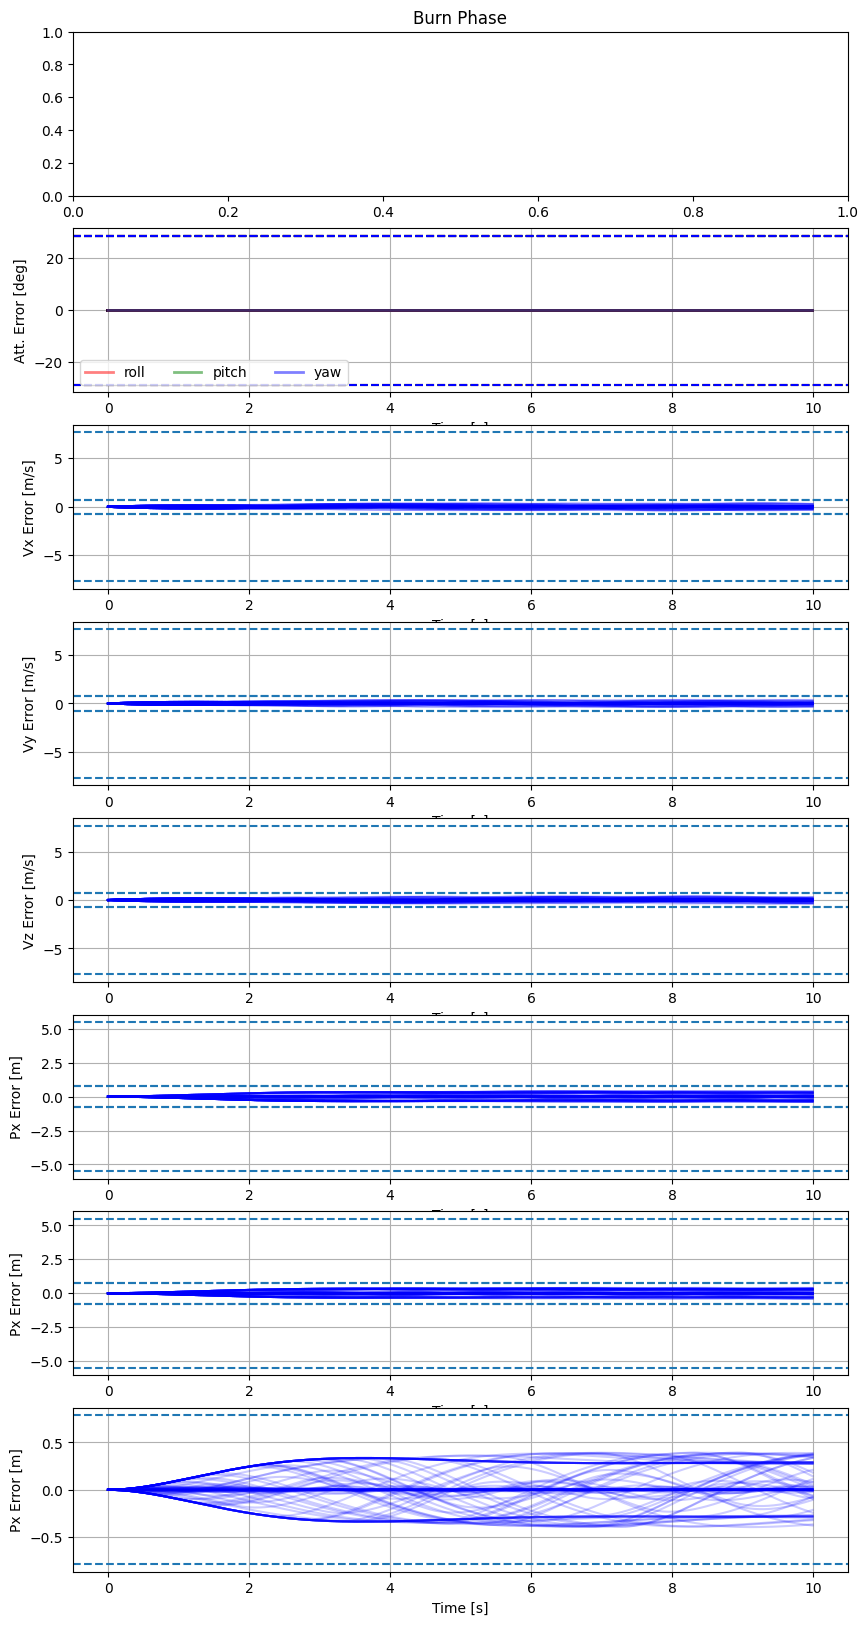

In [93]:
def burn_plotting(data_burn, bounds):
    fig, axes = plt.subplots(8, 1, figsize=(10, 20))
    axes[0].set_title('Burn Phase')
    colors = ['r','g','b']

    # Attitude
    plotting.plot_burn_attitude(axes[1], data_burn)
    for i in range(3):
        axes[1].axhline(y=np.rad2deg(bounds_log[6+i, 0]), linestyle='--', color=colors[i])
        axes[1].axhline(y=np.rad2deg(bounds_log[6+i, 1]), linestyle='--', color=colors[i])
        axes[1].axhline(y=np.rad2deg(bounds_log[6+i, 1]), linestyle='--', color=colors[i])

    # Vx
    plotting.plot_burn_delta_vx_error(axes[2], data_burn)
    axes[2].axhline(y=bounds_log[3, 0], linestyle='--')
    axes[2].axhline(y=bounds_log[3, 1], linestyle='--')

    axes[2].axhline(y=bounds_hcw[3, 0], linestyle='--')
    axes[2].axhline(y=bounds_hcw[3, 1], linestyle='--')

    axes[2].axhline(y=bounds_th[3, 0], linestyle='--')
    axes[2].axhline(y=bounds_th[3, 1], linestyle='--')
    

    #V y
    plotting.plot_burn_delta_vy_error(axes[3], data_burn)
    axes[3].axhline(y=bounds_log[4, 0], linestyle='--')
    axes[3].axhline(y=bounds_log[4, 1], linestyle='--')

    axes[3].axhline(y=bounds_hcw[4, 0], linestyle='--')
    axes[3].axhline(y=bounds_hcw[4, 1], linestyle='--')

    axes[3].axhline(y=bounds_th[4, 0], linestyle='--')
    axes[3].axhline(y=bounds_th[4, 1], linestyle='--')

    # Vz
    plotting.plot_burn_delta_vz_error(axes[4], data_burn)
    axes[4].axhline(y=bounds_log[5, 0], linestyle='--')
    axes[4].axhline(y=bounds_log[5, 1], linestyle='--')

    axes[4].axhline(y=bounds_hcw[5, 0], linestyle='--')
    axes[4].axhline(y=bounds_hcw[5, 1], linestyle='--')

    axes[4].axhline(y=bounds_th[5, 0], linestyle='--')
    axes[4].axhline(y=bounds_th[5, 1], linestyle='--')

    # Px
    plotting.plot_burn_x_error(axes[5], data_burn)
    axes[5].axhline(y=bounds_log[0, 0], linestyle='--')
    axes[5].axhline(y=bounds_log[0, 1], linestyle='--')

    axes[5].axhline(y=bounds_hcw[0, 0], linestyle='--')
    axes[5].axhline(y=bounds_hcw[0, 1], linestyle='--')

    axes[5].axhline(y=bounds_th[0, 0], linestyle='--')
    axes[5].axhline(y=bounds_th[0, 1], linestyle='--')

    # Py
    plotting.plot_burn_y_error(axes[6], data_burn)
    axes[6].axhline(y=bounds_log[1, 0], linestyle='--')
    axes[6].axhline(y=bounds_log[1, 1], linestyle='--')

    axes[6].axhline(y=bounds_hcw[1, 0], linestyle='--')
    axes[6].axhline(y=bounds_hcw[1, 1], linestyle='--')

    axes[6].axhline(y=bounds_th[1, 0], linestyle='--')
    axes[6].axhline(y=bounds_th[1, 1], linestyle='--')

    # Pz
    plotting.plot_burn_z_error(axes[7], data_burn)
    axes[7].axhline(y=bounds_log[2, 0], linestyle='--')
    axes[7].axhline(y=bounds_log[2, 1], linestyle='--')

    # axes[7].axhline(y=bounds_hcw[2, 0], linestyle='--')
    # axes[7].axhline(y=bounds_hcw[2, 1], linestyle='--')

    # axes[7].axhline(y=bounds_th[2, 0], linestyle='--')
    # axes[7].axhline(y=bounds_th[2, 1], linestyle='--')
    
burn_plotting(data_burn, bounds)